In [1]:
import pandas as pd               
import numpy as np
import math

In [2]:
import spiceypy as sp
import astropy.coordinates
import re
import sgp4.api as sg
import astropy.units as u
from astropy.coordinates import SkyCoord

In [3]:
import matplotlib.pyplot as plt
import os
import sys
from timeit import default_timer as timer
from astropy.time import Time
from astropy.time import TimeDelta
import datetime as dt
import timeit
import skyfield
# from skyfield.framelib import ecliptic_frame # For rotation matrices
from skyfield.api import EarthSatellite # For time calculations
from skyfield.api import load
from skyfield.api import N,S,E,W, wgs84
from skyfield.positionlib import Barycentric

In [4]:
#Earth shadow angle
np.arctan(690000/150000000)*180/np.pi

0.26355872680311504

In [5]:
# Number of arcseconds in 3 deg
3*3600


10800

In [6]:
#for 500km altitudes satellite is traveling degrees per 30 s
360/90/2

2.0

#### Let us start with reading in the first 10000 LSST observations for Main Belt Asteroids (S1 in the Synthetic Solar System model)

In [7]:
path = "/data/projects/lsst/baseline_fbs_v1p7p1/"
dir_list = os.listdir(path)

dflist=[]

for d in dir_list:
    if(d[0:2]=='S1'):
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0000000.h5'))
        dflist.append(pd.read_hdf('/data/projects/lsst/baseline_fbs_v1p7p1/'+d+'/visit-0010000.h5'))

In [8]:
# every dataframe looks like this
dflist[0].columns

Index(['ObjID', 'FieldID', 'FieldMJD', 'AstRange(km)', 'AstRangeRate(km/s)',
       'AstRA(deg)', 'AstRARate(deg/day)', 'AstDec(deg)',
       'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)', 'Ast-Sun(J2000y)(km)',
       'Ast-Sun(J2000z)(km)', 'Ast-Sun(J2000vx)(km/s)',
       'Ast-Sun(J2000vy)(km/s)', 'Ast-Sun(J2000vz)(km/s)',
       'Obs-Sun(J2000x)(km)', 'Obs-Sun(J2000y)(km)', 'Obs-Sun(J2000z)(km)',
       'Obs-Sun(J2000vx)(km/s)', 'Obs-Sun(J2000vy)(km/s)',
       'Obs-Sun(J2000vz)(km/s)', 'Sun-Ast-Obs(deg)', 'V', 'V(H=0)',
       'MaginFilterTrue', 'AstrometricSigma(mas)', 'PhotometricSigma(mag)',
       'SNR', 'AstrometricSigma(deg)', 'MaginFilter', 'dmagDetect',
       'AstRATrue(deg)', 'AstDecTrue(deg)', 'filter'],
      dtype='object')

In [9]:
# concatenate them into a single dataframe
dfin=pd.concat(dflist)

In [10]:
# we can sort the resulting dataframe by by FieldID
dfin.sort_values(['FieldID'], inplace=True)

In [11]:
# then grouping and counting is a little faster. It seems that FieldID 0 has the most observations
dfin.groupby(['FieldID']).count()['ObjID']

FieldID
0        390
1        363
2        164
3         96
4         77
        ... 
19992      3
19993      1
19996      2
19998      3
19999      1
Name: ObjID, Length: 16608, dtype: int64

In [12]:
def icrf2radec(pos, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        r=norm(pos,axis=1)
        xu=pos[:,0]/r
        yu=pos[:,1]/r
        zu=pos[:,2]/r
    else:
        r=norm(pos)
        xu=pos[0]/r
        yu=pos[1]/r
        zu=pos[2]/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec

In [13]:
def radec2icrf(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
    
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)
    
    return array([x, y, z])

In [16]:
###########################################
# OBSERVER STATES

###########################################
def getObserverStates(observationTimes,observerLatitudeDeg=0,observerLatitudeDirection='N',
                     observerLongitudeDeg=0,observerLongitudeDirection='W',observerElevationMeters=0):
    """Produce observer state vectors at observation times.
    Parameters
    ----------
    observationTimes
        Astropy Time array
    observerLatitudeDeg
        observer WGS84 latitude in degrees (float)
    observerLatitudeDirection
        observer latitude direciton ('N' for North or 'S' for South)
    observerLongitudeDeg
        observer WGS84 longitude in degrees (float)
    observerLatitudeDirection
        observer longitude direciton ('E' for East or 'W' for West)
    observerElevationMeters
        observer elevation in meters
    Returns
    -------
    observer positions
        WGS84 x,y,z observer positions at observation epochs in kilometers.
    observer velocities
        WGS84 dx/dt, dy/dt, dz/dt observer velocity at observation epochs in kilometers per second.
    """
    # load time scale object from skyfield
    ts = load.timescale()
    times = ts.from_astropy(observationTimes)
    if(observerLatitudeDirection == 'S'):
        latDir = S
    elif (observerLatitudeDirection == 'N'):
        latDir = N
    else:
        Error("Observer Latitude Direction unknown. Must be 'N' or 'S'.")
    if(observerLongitudeDirection == 'W'):
        lonDir = W
    elif (observerLongitudeDirection == 'E'):
        lonDir = E
    else:
        Error("Observer Longitude Direction unknown. Must be 'E' or 'W'.")
    observer = wgs84.latlon(observerLatitudeDeg * latDir, observerLongitudeDeg * lonDir, elevation_m=observerElevationMeters)
    observerAt = observer.at(times)
    return np.hstack([observerAt.position.km.T])

In [17]:
def getSatelliteStates(times,TLEFirstLine,TLESecondLine):
    """Produce satellite state vectors at observation times.
    Parameters
    ----------
    times
        Astropy Time array
    TLEFirstLine
        First Line of TLEs (str)
    TLESecondLine
        Second Line of TLEs (str)
    Returns
    -------
    satPositions
        x,y,z satellite geocentric positions in kilometers according to SGP4 propagation
    satVelocities
        dx/dt, dy/dt, dz/dt satellite geocentric velocities in kilometers/second according to SGP4 propagation
    """
    satPositions=[]
    satVelocities=[]
    r=0
    v=0
    e=0
    
    sat = sg.Satrec.twoline2rv(TLEFirstLine, TLESecondLine)  
    
    if(np.size(times)>1):
        for jd_t in times.jd:
#             print(jd_t)
            # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD

            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 10))  # r is [x,y,z] for propagated satellite

            satPositions.append(r)
            satVelocities.append(v)
#             print(r)
        return np.array(satPositions), np.array(satVelocities)
    else:
        fr, whole = math.modf(float(str(times.jd)))  # fr = digits after decimal of MJD
        e, r, v = sat.sgp4(float(str(times.jd)), round(fr, 10))  # r is [x,y,z] for propagated satellite
        return r,v
    


In [83]:
def crossTrackDistanceVectors(P1,P2,P3):
    # check if the point is within the line connecting P1 and P2
    v1=P3-P1
    v2=P3-P2
    
    if(np.dot(v1,v2)<0):
    
        S = np.cross(P1,P2)
        dot = np.dot(S,P3)
    
#     print('S',S)
#     print('dot',dot)
        dist = np.arctan2(dot/np.linalg.norm(S), np.sqrt(1 - (dot/np.linalg.norm(S))**2 )) 
    else:
        dist=1e10
    
    return dist

In [84]:
field_ids = dfin['FieldID'].unique()

In [85]:
dates = dfin['FieldMJD'].unique()

In [86]:
dates

array([59853.98564424, 59853.98609157, 59853.98653949, ...,
       59882.20925113, 59882.21018451, 59882.21064935])

In [87]:
print("Earliest field date: " + str(min(dates)) + " or 10-01-2022 at 23:39:19.663 UTC")
print("Last field date: " + str(max(dates)) + " or 10-30-2022 at 05:03:20.104 UTC")

Earliest field date: 59853.98564424414 or 10-01-2022 at 23:39:19.663 UTC
Last field date: 59882.21064935192 or 10-30-2022 at 05:03:20.104 UTC


In [88]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/home/eggl/projects/satellites/REU-Summer-2021': ['.git', 'Cross_Track_Distance.pdf', 'LICENSE', 'README.md', 'satellites - vector distance - Starlink  - Topocentric vector.ipynb', 'satellites - vector distance - Starlink 1 - Time.ipynb', 'satellites - vector distance - Starlink.ipynb', 'satellites - vector distance.ipynb', 'satellites.ipynb', 'satellites.py', 'starlink_tle.txt', '.ipynb_checkpoints', 'LSST_satellite_SSO_loss.ipynb']


In [89]:
# open the TLE files
# with open('/home/davidar6/Solution Testing/starlink_tle.txt') as f:
#     starlinks = f.read().splitlines() 

In [90]:
with open('starlink_tle.txt') as f:
    starlinks = f.read().splitlines() 

In [91]:
# split up the list into 3-line lists for each satellite
chunks = [starlinks[n:n + 3] for n in range(0, len(starlinks), 3)]

In [92]:
satdf=pd.DataFrame(chunks,columns=["SatID",'TLELine1',"TLELine2"])

In [93]:
satdf['SatNumber']=satdf.index

In [94]:
satdf

SatID  \
0     STARLINK-24                
1     STARLINK-61                
2     STARLINK-71                
3     STARLINK-43                
4     STARLINK-70                
...                        ...   
1648  STARLINK-2753              
1649  STARLINK-2715              
1650  STARLINK-3003              
1651  STARLINK-3004              
1652  STARLINK-3005              

                                               TLELine1  \
0     1 44238U 19029D   21237.86036098  .00007126  0...   
1     1 44249U 19029Q   21237.61543563  .00009867  0...   
2     1 44252U 19029T   21237.87426977  .00008416  0...   
3     1 44257U 19029Y   21238.10491661  .00042073  0...   
4     1 44281U 19029AY  21237.87370611  .00171460  0...   
...                                                 ...   
1648  1 48696U 21044BL  21237.91667824 -.00956927  0...   
1649  1 48697U 21044BM  21237.91667824 -.00956262  0...   
1650  1 48879U 21059A   21237.91667824 -.00033273  0...   
1651  1 48880U 21059B   21237.91667824 -.00033022  0...   
1652  1 48881U 21059C   21238.25001157  .00061182  0...   

                                               TLELine2  SatNumber  
0     2 44238  52.9979  31.4542 0001740 103.9964 256...          0  
1     2 44249  52.9845   4.5063 0002069 294.3150  65...          1  
2     2 44252  52.9989  32.1716 0002375 104.2717 255...          2  
3     2 44257  52.9970 267.2434 0002357  52.3365 307...          3  
4     2 44281  52.9909 290.5443 0007442  20.1280 340...          4  
...                                                 ...        ...  
1648  2 48696  53.0503 332.5553 0001149  65.0349 356...       1648  
1649  2 48697  53.0496 332.5640 0001102  68.4311 305...       1649  
1650  2 48879  97.5184   6.1245 0012660  94.2794  16...       1650  
1651  2 48880  97.5184   6.1227 0012864  95.5669  11...       1651  
1652  2 48881  97.5191   6.4643 0005101 132.3209   8...       1652  

[1653 rows x 4 columns]

In [95]:
print("There are " + str(len(chunks)) + " satellites")

There are 1653 satellites


In [ ]:
FOV_dist_lim = 3.5/180*np.pi #3 degrees distance to FOV for a satellite to be excluded
rearth = 6371
LSSTExpDays = 30/86400
distlim = 2/180/3600*np.pi # 2 arcsecond distance from satellite track
shadow=0
affected=[]

# check each satellite against each FIELD
for f in field_ids: #[100:1000]:

    data = dfin[dfin['FieldID']==f]  # all objects in the field

    sun_vector = data[['Obs-Sun(J2000x)(km)', 'Obs-Sun(J2000y)(km)', 'Obs-Sun(J2000z)(km)']][0:1].values[0]
    sv = sun_vector/np.linalg.norm(sun_vector)

    ra_f = data['AstRA(deg)']  # RA for all objects
    dec_f = data['AstDec(deg)']  # Dec for all objects
    range_f = data['AstRange(km)'] # Distance for all objects
    time_f = data['FieldMJD'].median()
    objID_f = data['ObjID']
    xyzu = radec2icrf(ra_f, dec_f, deg=True)
    
    FOV_mean_direction=np.median(xyzu,axis=1)
#     print(xyzu)
#     print('md',mean_direction)
#     min_ra, max_ra = min(ra_f), max(ra_f) # Global minimum and maximums for objects in the field in question
#     min_dec, max_dec = min(dec_f), max(dec_f)
    
    time = Time(time_f, format='mjd', scale='utc')
    print(time.jd)
    observer_state = getObserverStates(time,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                  observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
    
    for index, row in satdf.iterrows():
        
        sat_r,sat_v = getSatelliteStates(time,row['TLELine1'],row['TLELine2'])
       
        
        # print('time',time,sat_r)
        
        #Is the satellite in Earth's Shadow?
        r_parallel = np.dot(sat_r,sv)*sv
        r_tangential = sat_r-r_parallel
            
        if(np.linalg.norm(r_tangential)<rearth):
            #print(np.linalg.norm(r_tangential),np.linalg.norm(r))
            #yes the satellite is in Earth's shadow, no need to continue (except for the moon of course)
            shadow=shadow+1
            continue
#         else:
#             print('not in shadow')
            # break
            
            
        #Is the satellite near the FOV?
        sat_d = np.linalg.norm(sat_r)
        ang_dist = np.arccos(np.dot(FOV_mean_direction,sat_r)/sat_d)
        
        if(ang_dist < FOV_dist_lim):
            continue
        
        tminus = Time(time.mjd-LSSTExpDays/2,format='mjd',scale='utc')
        tplus = Time(time.mjd+LSSTExpDays/2,format='mjd',scale='utc')
#         print((tminus-tplus)*86400,'timestuff')
#         print(tminus.jd)
        # do a more thorrow analysis by propagating the satellite to +15 and -15 secs and check for cross track distance
        R1,V1 = getSatelliteStates(tminus,row['TLELine1'],row['TLELine2'])
        R2,V2 = getSatelliteStates(tplus,row['TLELine1'],row['TLELine2'])
#         print('R1, R2',np.array(R1),np.array(R2))
#         print('R1-R2',np.array(R1)-np.array(R2))
        
        OBSERV1 = getObserverStates(tminus,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                  observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
        OBSERV2 = getObserverStates(tplus,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                  observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
   
        O1 = np.array(R1)-OBSERV1
        O2 = np.array(R2)-OBSERV2
        
        P1 = O1/np.linalg.norm(O1)
        P2 = O2/np.linalg.norm(O2)

        i = 0
        for obj in objID_f: 
            P3 = xyzu[:,i]
#             print('P1',P1,'P2',P2,'P3',P3)
            cdist = np.abs(crossTrackDistanceVectors(P1,P2,P3))
            #print('dist [arcsec]',dist*3600*180/np.pi)
            adist = np.arccos(np.dot(P1,P3))
            if ((cdist <= distlim) & (adist <= 2*FOV_dist_lim)):
                affected.append([time,cdist*3600*180/np.pi,obj,f,ra_f.values[i],dec_f.values[i],row,P1,P2,P3])
                print([time,cdist*3600*180/np.pi,obj,f,ra_f.values[i],dec_f.values[i],row,P1,P2,P3])
            i=i+1
    #radec2icrf(ra, dec, deg=True)
        
        #Is it in the extended FOV?
        
  
    
    
    
    

2459854.485644244
2459854.486091567
2459854.486539486
2459854.486989325
2459854.487435972
2459854.487885024
2459854.488333626
2459854.488780301
2459854.489228787
2459854.4896775614
2459854.490127953
2459854.490576159
2459854.4910248574
2459854.4914785726


/tmp/ipykernel_197448/752707388.py:57: RuntimeWarning: invalid value encountered in arccos
  ang_dist = np.arccos(np.dot(FOV_mean_direction,sat_r)/sat_d)


2459854.4919266794
2459854.4923743526
2459854.4928221605
2459854.4932701136
2459854.4937181734
2459854.4941660077
2459854.494614941
2459854.4950626804
2459854.495512189
2459854.49595963
2459854.4964090814
2459854.4968565283
2459854.4973153193
2459854.4977635783
2459854.4982113293
2459854.498659809
2459854.499108822
2459854.499555777
2459854.5000024606
2459854.500456982
2459854.5009056213
2459854.5013529877
2459854.501801947
2459854.5022511273
2459854.502700702
2459854.5031551854
2459854.5036050575
2459854.505387465
2459854.5058682766
2459854.506329134
2459854.506803311
2459854.5072530475
2459854.507704907
2459854.5081527834
2459854.5086021307
2459854.5090486826
2459854.5094956374
2459854.5149362506
2459854.5158319166
2459854.5162795517
2459854.516736538
2459854.517184381
2459854.517631982
2459854.5181099335
2459854.5185580896
2459854.5190059883
2459854.5195011985
2459854.519964134
2459854.5204515797
2459854.520913765
2459854.521374689
2459854.521855559
2459854.522309818
2459854.5227578

2459854.6494496185
2459854.649896695
2459854.650344188
2459854.650791614
[<Time object: scale='utc' format='mjd' value=59854.150791613625>, 1.4450603798639508, 'S1000avPa', 357, 315.3113828086491, -12.661386863306753, SatID                                 STARLINK-1510           
TLELine1     1 45784U 20038BG  21237.86695420 -.00000552  0...
TLELine2     2 45784  53.0552  74.3931 0001989  78.9694 281...
SatNumber                                                  459
Name: 459, dtype: object, array([ 0.68941064, -0.69081432, -0.21791869]), array([ 0.7188936 , -0.65711866, -0.22668713]), array([ 0.69365093, -0.6861521 , -0.21918872])]
2459854.6512405532
[<Time object: scale='utc' format='mjd' value=59854.151240553205>, 1.9263719129648063, 'S1005Fzla', 358, 317.43778421134465, -13.579136578778137, SatID                                 STARLINK-1017           
TLELine1     1 44723U 19074L   21238.03374543  .00001008  0...
TLELine2     2 44723  53.0561  63.6324 0001802  96.7921 263...
SatNum

[<Time object: scale='utc' format='mjd' value=59854.27779057182>, 1.7069663869774228, 'S102TeUqa', 619, 36.399478742795736, -3.1265047674150326, SatID                                 STARLINK-1789           
TLELine1     1 46690U 20073W   21237.93559647  .00000894  0...
TLELine2     2 46690  53.0548 109.0647 0002151  77.1530 282...
SatNumber                                                  714
Name: 714, dtype: object, array([ 0.80978797,  0.58337625, -0.06257473]), array([ 0.78730345,  0.61563871, -0.03379736]), array([ 0.80370114,  0.5925283 , -0.05454073])]
2459854.7782101906
[<Time object: scale='utc' format='mjd' value=59854.27821019038>, 1.0027818717243673, 'S100thAxa', 620, 37.72897037887799, -4.107864515170473, SatID                                 STARLINK-2595           
TLELine1     1 48407U 21038BG  21238.25001157 -.00012057  0...
TLELine2     2 48407  53.0464 217.7023 0001946  68.4863 352...
SatNumber                                                 1469
Name: 1469, dtype: 

2459855.5738643124
2459855.5743979393
2459855.5748757515
2459855.5753250574
2459855.575789757
2459855.5762649477
2459855.576720063
2459855.577178204
2459855.577637299
2459855.578174759
2459855.578626807
2459855.579079201
2459855.5795316226
2459855.5799804404
2459855.5804275726
2459855.5808778135
2459855.5813247077
2459855.5817719363
2459855.5822206596
2459855.5826673806
2459855.583116341
2459855.583564911
2459855.5840143547
2459855.5844638413
2459855.584909855
2459855.5853603757
2459855.5858093076
2459855.5862561134
2459855.5867052274
2459855.5871683448
2459855.5876308363
2459855.5881240536
2459855.5885955268
2459855.5890441737
2459855.589538886
2459855.589999815
2459855.590449324
2459855.590901589
2459855.5913547375
2459855.5918055265
2459855.5922572277
2459855.5927096205
2459855.5932216006
2459855.5936719663
2459855.5941229793
2459855.5945744338
2459855.5950220907
2459855.595470105
2459855.595919977
2459855.5963677713
2459855.5968485167
2459855.597297319
2459855.5977435145
2459855.59

2459856.7187605556
2459856.719210478
2459856.7196622114
2459856.720111732
2459856.7205646373
2459856.721012036
2459856.7214781214
2459856.721930615
2459856.7223977367
2459856.722847637
2459856.7232954022
2459856.7237424115
2459856.7242066152
2459856.7246542517
2459856.7251055688
2459856.7255566153
2459856.7260036455
2459856.7264535236
2459856.7269002697
2459856.727348613
2459856.7277961066
2459856.728242408
2459856.728688652
2459856.729134915
2459856.7295803456
2459856.730026098
2459856.730471376
2459856.73091623
2459856.731368074
2459856.7318125796
2459856.7322575385
2459856.7327029738
2459856.733148915
2459856.733603248
2459856.7340494804
2459856.7344963774
2459856.7349439953
2459856.7354036095
2459856.7358516525
2459856.7363005015
2459856.736746753
2459856.7371968394
2459856.7376473164
2459856.7380945156
2459856.738563119
2459856.7390135485
2459856.7394596506
2459856.7399093895
2459856.7403589045
2459856.7408060455
2459856.7412546524
2459856.7417015517
2459856.742148877
2459856.7425

2459857.6124946657
2459857.612943975
2459857.6133938422
2459857.613840612
2459857.614291139
2459857.614737268
2459857.6151884804
2459857.61563513
2459857.6160842148
2459857.616591686
2459857.617039736
2459857.6175241517
2459857.6179796536
2459857.6184283295
2459857.6188765606
2459857.6193294795
2459857.619854275
2459857.620301761
2459857.620749438
2459857.6211984335
2459857.621648726
2459857.62209987
2459857.6225479203
2459857.6229962856
2459857.6234458783
2459857.6238936684
2459857.6243425473
2459857.6247899453
2459857.6252383958
2459857.6256864504
2459857.626133797
2459857.62658372
2459857.6270324877
2459857.6274793153
2459857.627929442
2459857.628379816
2459857.6288275453
2459857.629278789
2459857.629725797
2459857.630179762
2459857.6306272163
2459857.631074394
2459857.6315371958
2459857.631984961
2459857.632431838
2459857.632883761
2459857.633359823
2459857.633810944
2459857.6342787817
2459857.6347268457
2459857.6351741594
2459857.6356240064
2459857.6360705676
2459857.6365204095
24

2459858.5102494974
2459858.5107202213
2459858.5111703956
2459858.5161669995
2459858.5170803177
2459858.517547108
2459858.518011468
2459858.518460561
2459858.5189240533
2459858.519378421
2459858.5198431667
2459858.5203102645
2459858.520793269
2459858.5212655608
2459858.5217140396
2459858.5234964467
2459858.524016697
2459858.5244646613
2459858.524939722
2459858.5253881807
2459858.525836928
2459858.5263314997
2459858.526780759
2459858.52724925
2459858.527701436
2459858.5281507885
2459858.532692902
2459858.5336042945
2459858.5340685304
2459858.534530127
2459858.5349791143
2459858.5354394396
2459858.535893135
2459858.5363540575
2459858.5368175237
2459858.5372923296
2459858.5377617246
2459858.5382112963
2459858.538677999
2459858.5391268767
2459858.5396017767
2459858.540073422
2459858.5405442463
2459858.541012994
2459858.541563567
2459858.5420215284
2459858.542469745
2459858.5429306957
2459858.5433904575
2459858.5465704766
2459858.5470232363
2459858.547920795
2459858.5483879275
2459858.548851

2459858.7604604205
2459858.76090795
2459858.7613576395
2459858.7618050794
2459858.7622521776
2459858.762699032
2459858.763148991
2459858.763596179
2459858.7640428664
2459858.764489876
2459858.7649368076
2459858.765384334
2459858.765832399
2459858.766302783
2459858.7667512884
2459858.767282247
2459858.7677323953
2459858.7681808393
2459858.7686321996
2459858.769080023
2459858.7695308886
2459858.769987501
2459858.770436551
2459858.770888055
2459858.7713368624
2459858.771784483
2459858.7722362312
2459858.772684706
2459858.773133333
2459858.773581989
2459858.7740298244
2459858.774478539
2459858.7749256417
2459858.7753726523
2459858.775820895
2459858.776270258
2459858.776718392
2459858.777166299
2459858.777612877
2459858.7780626095
2459858.778509594
2459858.778956243
2459858.7794023408
2459858.7798493695
2459858.7802967844
2459858.7807445144
2459858.781207351
2459858.781655647
2459858.7821770473
2459858.7826259676
2459858.783074885
2459858.783524677
2459858.7839717963
2459858.784420646
24598

2459859.6076586777
2459859.608107318
2459859.608605121
2459859.609069064
2459859.6095185964
2459859.609985294
2459859.610455069
2459859.6109044733
2459859.6113970336
2459859.611855641
2459859.6123049944
2459859.612764489
2459859.613225012
2459859.613740668
2459859.6141981357
2459859.619337671
2459859.619784504
2459859.6202564435
2459859.6207338567
2459859.621188545
2459859.621640041
2459859.6220950284
2459859.6225666394
2459859.6230146587
2459859.623462135
2459859.6239511203
2459859.6244084924
2459859.624857912
2459859.6253168834
2459859.625779362
2459859.6262290953
2459859.626716741
2459859.627173623
2459859.6276222174
2459859.6280809147
2459859.629053264
2459859.6295097345
2459859.6346407877
2459859.635091573
2459859.635536801
2459859.635982707
2459859.6364364186
2459859.6373324115
2459859.63778217
2459859.638227773
2459859.6386776958
2459859.639123246
2459859.6395685403
2459859.6400135304
2459859.6404581317
2459859.6409022994
2459859.6413469044
2459859.641791513
2459859.6422372684
2

2459859.8567487993
2459859.858119159
2459859.8586471947
2459859.8591036396
2459859.859551918
2459859.860018529
2459859.860493518
2459859.8609907674
2459859.861447296
2459859.8618964925
2459859.8623451977
2459859.8628127906
2459859.863269014
2459859.863725696
2459859.864175786
2459859.864633818
2459859.8650839766
2459859.865538489
2459859.8659867956
2459859.8664357164
2459859.866883113
2459859.8673411296
2459859.867788758
2459859.8682346223
2459859.8686812255
2459859.869145725
2459859.8696019235
[<Time object: scale='utc' format='mjd' value=59859.36960192344>, 1.2073067303876985, 'S1009vwpa', 4489, 62.80166670801964, -13.071856258462645, SatID                                 STARLINK-1187           
TLELine1     1 45219U 20012AT  21237.50481320  .00000407  0...
TLELine2     2 45219  53.0535 246.0144 0000827  50.7037 309...
SatNumber                                                  213
Name: 213, dtype: object, array([ 0.46374442,  0.85941893, -0.21526779]), array([ 0.43136997,  0.871256

2459860.694144649
2459860.694591401
2459860.6950375577
2459860.6954963026
2459860.695942282
2459860.696392263
2459860.6968453606
2459860.6972912266
2459860.6977366875
2459860.6981885633
2459860.698634298
2459860.6990841934
2459860.6995388353
2459860.699982964
2459860.7004328757
2459860.7008774243
2459860.7013374395
2459860.701782462
2459860.7022351352
2459860.7026846567
2459860.7031304063
2459860.703576329
2459860.7040275275
2459860.7044726945
2459860.7049189364
2459860.7053642552
2459860.7058091965
2459860.706259081
2459860.7067034408
2459860.7071534256
2459860.708935833
2459860.7093970203
2459860.709843163
2459860.7102895733
2459860.7107350607
2459860.7111800355
2459860.7116327304
2459860.712077626
2459860.7125275694
2459860.7129790955
2459860.713424399
2459860.7138694115
2459860.714320396
2459860.714765562
2459860.715215403
2459860.715669725
2459860.716114181
2459860.7165640444
2459860.7170088394
2459860.717468764
2459860.717913945
2459860.7183667296
2459860.7188162426
2459860.71926

2459861.506548772
2459861.506994176
2459861.5091932504
2459861.5096470914
2459861.5100958645
2459861.510543229
2459861.5110287187
2459861.5114767533
2459861.5119235436
2459861.5123695075
2459861.5128419893
2459861.513288273
2459861.513734216
2459861.5141806826
2459861.5146290325
2459861.5150750065
2459861.5155208283
2459861.515967687
2459861.5164172035
2459861.5168655063
2459861.517315426
2459861.517766128
2459861.518214902
2459861.518666118
2459861.519115004
2459861.519568721
2459861.520078745
2459861.520535233
2459861.5209923238
2459861.521450257
2459861.5219150377
2459861.5223851698
2459861.522995069
2459861.523463356
2459861.5239214664
2459861.5244389665
2459861.5249060025
2459861.5253545735
2459861.525801278
2459861.526294571
2459861.526742528
2459861.5271890922
2459861.5276361546
2459861.528112597
2459861.5285590915
2459861.5290060737
2459861.529453461
2459861.5299026547
2459861.530349611
2459861.5307961483
2459861.5312429653
2459861.531694169
2459861.5321431067
[<Time object: sc

2459861.634761053
[<Time object: scale='utc' format='mjd' value=59861.1347610533>, 1.3131521927424743, 'S1007DUPa', 5502, 317.28878914271115, -12.262158901912487, SatID                                 STARLINK-1506           
TLELine1     1 45747U 20038T   21237.93698202  .00001232  0...
TLELine2     2 45747  53.0543 114.0760 0002151  85.7391 274...
SatNumber                                                  423
Name: 423, dtype: object, array([ 0.7112031 , -0.6709705 , -0.20973492]), array([ 0.73867226, -0.63698129, -0.2204952 ]), array([ 0.71801862, -0.66282868, -0.21238505])]
2459861.63520869
[<Time object: scale='utc' format='mjd' value=59861.13520868991>, 0.3162989057336012, 'S100vX7Fa', 5503, 318.2393603567348, -13.252476603190384, SatID                                 STARLINK-2162           
TLELine1     1 47748U 21017AC  21237.84621340  .00001034  0...
TLELine2     2 47748  53.0572  79.4666 0002189  97.9054 262...
SatNumber                                                 1082
N

2459862.509088463
2459862.509535733
2459862.5099935676
2459862.5104411943
2459862.51088847
2459862.5113397758
2459862.5117904567
2459862.5122613427
2459862.5127114244
2459862.513160932
2459862.513626304
2459862.5140753556
2459862.51452344
2459862.514968861
2459862.5154164475
2459862.5158626745
2459862.516310828
2459862.5167575716
2459862.517206581
2459862.5176535337
2459862.5181036396
2459862.5185499554
2459862.519000912
2459862.51944801
2459862.5198948756
2459862.5203505964
2459862.5207977523
2459862.5212588045
2459862.5217088913
2459862.5221751053
2459862.5226264275
2459862.523107386
2459862.5235570916
2459862.525339499
2459862.5257898197
2459862.526250406
2459862.5266992287
2459862.5271464703
2459862.5275989706
2459862.5280493475
2459862.528526633
2459862.528976645
2459862.5294256844
2459862.529895226
2459862.5303440196
2459862.530791502
2459862.531237484
2459862.531684636
2459862.5321296016
2459862.5325777675
2459862.5330233807
2459862.5334725245
2459862.533918326
2459862.534368904

2459862.7017739313
2459862.702218779
2459862.7026752657
2459862.703120678
2459862.703565675
2459862.704011376
2459862.704457809
2459862.704904962
2459862.705373298
2459862.7058213605
2459862.7062697955
2459862.706718494
2459862.7071669465
2459862.707614879
2459862.7080625836
2459862.7085099635
2459862.708956937
2459862.709403438
2459862.709853543
2459862.7103001513
2459862.7107461398
2459862.711191495
2459862.7116378415
2459862.7120831558
2459862.7138655633
2459862.7143177325
2459862.714767769
2459862.715217867
2459862.715662063
2459862.716106764
2459862.7165513523
2459862.7170013613
2459862.7174528013
2459862.7178978873
2459862.7183426204
2459862.7187946416
2459862.7192398524
2459862.71968471
2459862.720129439
2459862.7205747366
2459862.7210205947
2459862.7214801568
2459862.721926833
2459862.7223738665
2459862.7228211956
2459862.7232690295
2459862.7237158264
2459862.7241623523
2459862.7246085512
2459862.7250543763
2459862.72549979
2459862.7259498974
2459862.726395356
2459862.72684031


2459863.5186727354
2459863.519162021
2459863.5196100785
2459863.5200622543
2459863.520511431
2459863.52101243
2459863.5214606863
2459863.5219113333
2459863.5223858887
2459863.5228676996
2459863.523409016
2459863.5239032335
2459863.5244055754
2459863.5249794866
2459863.526761894
2459863.5272356505
2459863.527709657
2459863.5281597213
2459863.5286134686
2459863.5290655857
2459863.5295156604
2459863.5299663274
2459863.530415048
2459863.530862401
2459863.5313116917
2459863.5317581724
2459863.5322066406
2459863.532656391
2459863.533150603
2459863.533600856
2459863.5340510863
2459863.5344995484
2459863.5349468985
2459863.5353968637
2459863.535877569
2459863.5363277253
2459863.5367789427
2459863.5372324986
2459863.53774373
2459863.538197773
2459863.538657827
2459863.5391245997
2459863.5396090276
2459863.540175729
2459863.5406581536
2459863.5411697077
2459863.5417891713
2459863.5423649414
2459863.542828678
2459863.543278139
2459863.543729561
2459863.544181315
2459863.5446314504
2459863.5450813

2459863.716948237
2459863.717396231
2459863.7178438683
2459863.719626276
2459863.720075743
2459863.7205230272
2459863.7209695373
2459863.721418758
2459863.7218645657
2459863.7223100704
2459863.7227596464
2459863.7232051822
2459863.723662801
2459863.724112297
2459863.72455883
2459863.7250133185
2459863.725460082
2459863.725909759
2459863.726357357
2459863.7268056674
2459863.7272548345
2459863.727711667
2459863.7281599487
2459863.728608299
2459863.729068041
2459863.729517121
2459863.730041343
2459863.730490408
2459863.7309556934
2459863.731403719
2459863.7318531605
2459863.7323004557
2459863.7327494514
2459863.7331978343
2459863.73364477
2459863.734091393
2459863.7345808744
2459863.735074316
2459863.7355242115
2459863.735971545
2459863.7364213364
2459863.736877469
2459863.7373254444
2459863.7377747297
2459863.7382229115
2459863.738672427
2459863.739120511
2459863.7395677213
2459863.740014994
2459863.7404926447
2459863.7409400344
2459863.7413897635
2459863.7418404995
2459863.7422880824
24

2459864.5797654386
2459864.5802369546
2459864.5806872873
2459864.581148592
2459864.581612967
2459864.582073335
2459864.582532157
2459864.5829913896
2459864.58344767
2459864.583899838
2459864.584438552
2459864.584896472
2459864.5853510057
2459864.585887861
2459864.586346728
2459864.5868028025
2459864.587255734
2459864.5877356594
2459864.5881945645
2459864.5886562783
2459864.5891037737
2459864.589567286
2459864.5900154402
2459864.590463291
2459864.5909486352
2459864.5913972934
2459864.5918667233
2459864.5924279206
2459864.592899032
2459864.593372042
2459864.595154449
2459864.5956543777
2459864.5961342454
2459864.5966607668
2459864.5971241756
2459864.5975741693
2459864.5980350343
2459864.598509696
2459864.598975549
2459864.599446641
2459864.5999161643
2459864.6003817674
2459864.6008423227
2459864.6014190707
2459864.6018845136
2459864.6023465614
2459864.6029115967
2459864.603376184
2459864.603838473
2459864.604297617
2459864.60479009
2459864.605254165
2459864.605720343
2459864.6061690627
2

2459864.7810915825
[<Time object: scale='utc' format='mjd' value=59864.28109158255>, 1.9245034991189989, 'S1002Pzda', 8300, 30.52498949456077, -13.628960968733201, SatID                                 STARLINK-1860           
TLELine1     1 47147U 20088AB  21237.28042249 -.00000776  0...
TLELine2     2 47147  53.0562 182.0243 0001619  50.5260 309...
SatNumber                                                  832
Name: 832, dtype: object, array([ 0.84178435,  0.48507559, -0.23685603]), array([ 0.81827339,  0.52651066, -0.23068417]), array([ 0.83715222,  0.49361228, -0.23563337])]
2459864.7815427375
[<Time object: scale='utc' format='mjd' value=59864.28154273761>, 0.25458636113575533, 'S100tKsZa', 8301, 29.99179172174479, -14.321068525361966, SatID                                 STARLINK-1934           
TLELine1     1 46792U 20074BF  21237.60386095 -.00000888  0...
TLELine2     2 46792  53.0553 190.5685 0001347  51.5520 308...
SatNumber                                                  8

2459865.5085857837
[<Time object: scale='utc' format='mjd' value=59865.00858578378>, 0.4376424267372043, 'S100xlYra', 8559, 291.5742150978947, -9.299721396449959, SatID                                 STARLINK-2469           
TLELine1     1 48128U 21027AN  21238.07010880  .00021521  0...
TLELine2     2 48128  53.0478   2.8752 0004716   8.8236 351...
SatNumber                                                 1331
Name: 1331, dtype: object, array([ 0.34625741, -0.92603693, -0.15020453]), array([ 0.37673215, -0.91037575, -0.17113993]), array([ 0.36287314, -0.91771937, -0.16159902])]
2459865.5090339365
2459865.509489523
2459865.510242711
2459865.510691386
2459865.511138218
2459865.511586159
2459865.5120328553
2459865.5124978134
2459865.512950531
2459865.513398734
2459865.513846442
2459865.514293599
2459865.514740711
2459865.5151872733
2459865.5156370476
2459865.516083659
2459865.5165334716
2459865.516978562
2459865.5174283865
2459865.5178734083
2459865.5183202806
2459865.518765202
2459865.5

2459865.6090340866
2459865.6094802567
2459865.6099261288
2459865.61037609
2459865.6108225533
2459865.6112725465
2459865.611719757
2459865.612166582
2459865.6126167164
2459865.6130643664
2459865.6135309734
2459865.6139790826
2459865.6144264317
2459865.6148748887
2459865.615324892
2459865.6157741584
2459865.6162274634
2459865.6166846673
2459865.617134394
2459865.617581531
2459865.6180319167
2459865.618479006
2459865.6189284837
2459865.6193767227
2459865.61982535
2459865.620273492
2459865.6207214147
2459865.6211693813
2459865.622951789
2459865.6233990123
2459865.6238462464
2459865.6242934475
2459865.624741843
2459865.625188524
2459865.625635073
2459865.6260814476
2459865.626531195
2459865.62697817
2459865.6274277605
2459865.6278754817
2459865.6283229887
2459865.628772885
2459865.629221248
2459865.6296863314
2459865.630135426
2459865.6305829072
2459865.631030019
2459865.6314824573
2459865.631929842
2459865.632388011
2459865.63284911
2459865.6332975253
2459865.633745938
2459865.6341967853
2

2459865.8089992455
2459865.8094494673
2459865.8098993753
2459865.8103492404
2459865.8107980434
2459865.8112462847
2459865.811694504
2459865.812142441
2459865.812593969
2459865.8130412023
2459865.8134893803
2459865.8139361953
2459865.8143829773
2459865.81483046
2459865.815276888
2459865.81572398
2459865.816173174
2459865.816620178
2459865.8170679277
2459865.8175151944
2459865.817962316
2459865.818409818
2459865.818857337
2459865.8193045887
2459865.8197530448
2459865.820200496
2459865.820649458
2459865.821097572
2459865.8215469867
2459865.8219967643
2459865.822446122
2459865.823111795
2459865.823561633
2459865.824010833
2459865.8244596757
2459865.8249084186
2459865.825357898
2459865.825805787
2459865.826254484
2459865.8267018213
2459865.8271502075
2459865.8276002747
2459865.828046731
2459865.83001087
2459865.834167013
2459865.834660513
2459865.83556837
2459865.836037784
2459865.836969453
2459865.8383765854
2459865.841157104
2459865.851243275
2459865.852182844
2459865.8526608273
2459865.8

2459866.6635558205
2459866.663972487
2459866.664389154
2459866.6648058207
2459866.6652224874
2459866.665639154
2459866.666055821
2459866.666472487
2459866.666889154
2459866.669088228
2459866.6695406176
2459866.6699887025
2459866.6704416233
2459866.6708901376
2459866.671345998
2459866.671800417
2459866.6722903205
2459866.6727381973
2459866.673310281
2459866.673764661
2459866.6742131496
2459866.6746578407
2459866.675104469
2459866.6755522634
[<Time object: scale='utc' format='mjd' value=59866.175552263354>, 1.3574868004455394, 'S100kHMXa', 9720, 340.1127402933865, -13.601034356516882, SatID                                 STARLINK-1161           
TLELine1     1 45068U 20006AA  21237.93055425  .00000256  0...
TLELine2     2 45068  53.0546 144.1130 0001642  90.2235 269...
SatNumber                                                  142
Name: 142, dtype: object, array([ 0.90720607, -0.3498272 , -0.23366231]), array([ 0.92212158, -0.30587902, -0.23691733]), array([ 0.91399294, -0.33063098, -0.

2459866.700511692
2459866.7009578845
2459866.7014056705
2459866.701852842
2459866.702307097
2459866.7027561134
2459866.7032022155
2459866.7036512997
2459866.704096932
2459866.70454205
2459866.7049909933
2459866.7054373305
2459866.7058827733
2459866.70632957
2459866.706787763
2459866.707236238
2459866.707682987
2459866.7081317306
2459866.708581268
2459866.7090301574
2459866.7094780905
2459866.709927074
2459866.710376029
2459866.7108245594
2459866.7112735836
2459866.711720469
2459866.712169536
2459866.7126160325
2459866.713064534
2459866.7135133776
2459866.713962367
2459866.714410347
2459866.7148561687
2459866.716638576
2459866.7170839594
2459866.7175311144
2459866.7179769636
2459866.7184303314
2459866.7188793626
2459866.7193244984
2459866.7197735626
2459866.720218322
2459866.7206633436
2459866.721112338
2459866.7215578253
2459866.722003241
2459866.7224490982
2459866.7229075045
2459866.7233548816
2459866.723801743
2459866.72425064
2459866.724698696
2459866.725147619
2459866.7255942337
24

[<Time object: scale='utc' format='mjd' value=59867.00751211013>, 1.541066967658736, 'S100osAWa', 10190, 289.1047936348074, -13.214209994177155, SatID                                 STARLINK-2169           
TLELine1     1 47752U 21017AG  21237.83654174  .00000605  0...
TLELine2     2 47752  53.0573  84.5110 0002063  87.8632 272...
SatNumber                                                 1086
Name: 1086, dtype: object, array([ 0.28237969, -0.93063226, -0.23277738]), array([ 0.32742321, -0.9170742 , -0.22752791]), array([ 0.31863087, -0.91990213, -0.22859232])]
2459867.507959823
2459867.508408855
2459867.5088599045
2459867.5097473683
2459867.510217988
2459867.5120003955
2459867.5137828025
2459867.5142642343
2459867.514743758
2459867.51519568
2459867.515644575
2459867.516102066
2459867.5165579757
2459867.5170079684
2459867.51745821
2459867.517943834
2459867.518393748
2459867.5188436797
2459867.519291773
2459867.5197545174
2459867.520201726
2459867.5206482387
2459867.521098293
2459867.52

In [107]:
affected

[[<Time object: scale='utc' format='mjd' value=59854.132590209>,
  0.0498562666660288,
  'S1006jZra',
  318,
  308.080007214229,
  -13.475986611131564,
  SatID                                 STARLINK-1705           
  TLELine1     1 46579U 20070AZ  21237.86096726  .00000992  0...
  TLELine2     2 46579  53.0569  39.4245 0001841 103.2037 256...
  SatNumber                                                  684
  Name: 684, dtype: object,
  array([ 0.59898189, -0.76607142, -0.23314215]),
  array([ 0.63544478, -0.73770513, -0.22803745]),
  array([ 0.59978037, -0.76547821, -0.23303781])],
 [<Time object: scale='utc' format='mjd' value=59854.13586003526>,
  0.6707658350459084,
  'S100aVSoa',
  324,
  312.80511077659537,
  -10.909780671266361,
  SatID                                 STARLINK-2213           
  TLELine1     1 47780U 21017BL  21237.89226496  .00000558  0...
  TLELine2     2 47780  53.0558  89.2650 0002165  82.5660 277...
  SatNumber                                               

In [108]:
len(affected)

391

In [114]:
dfinsel=dfin[dfin['FieldMJD']<(59882.11358696042)]

In [115]:
dfinsel

ObjID  FieldID      FieldMJD  AstRange(km)  AstRangeRate(km/s)  \
111366   S100Wleya        0  59853.985644  2.056206e+08           17.370899   
63558    S100jyqsa        0  59853.985644  3.288825e+08           20.335665   
369697   S100b94pa        0  59853.985644  2.935399e+08           17.249312   
413551   S100vRfSa        0  59853.985644  2.577908e+08           22.867207   
573352   S100gdaEa        0  59853.985644  2.327450e+08           12.783566   
...            ...      ...           ...           ...                 ...   
1178265  S100gevaa    19799  59882.113137  2.002503e+08            8.508179   
470776   S101aEQja    19799  59882.113137  1.837642e+08            9.753162   
4287     S100cvhda    19799  59882.113137  1.359502e+08            7.607184   
1171548  S100c4zHa    19799  59882.113137  1.912908e+08            8.745313   
251261   S100EhzSa    19799  59882.113137  1.834086e+08            6.121709   

         AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  AstDecRate(deg/day)  \
111366   301.079569            0.255404    -3.736211            -0.098705   
63558    299.120209            0.110035    -5.641129            -0.083445   
369697   298.756780            0.107245    -3.460878            -0.000689   
413551   299.266428            0.213605    -3.340036            -0.127344   
573352   298.604100            0.132909    -5.223844            -0.032788   
...             ...                 ...          ...                  ...   
1178265   18.220486           -0.216311   -18.289327             0.091750   
470776    20.411828           -0.112595   -18.109565            -0.080111   
4287      18.459413           -0.193983   -16.718151             0.158528   
1171548   20.565866           -0.164696   -18.601360            -0.026117   
251261    18.884731           -0.208023   -17.435613             0.047767   

         Ast-Sun(J2000x)(km)  ...  MaginFilterTrue  AstrometricSigma(mas)  \
111366          2.540524e+08  ...        22.575089             145.883978   
63558           3.074044e+08  ...        22.326143             116.582572   
369697          2.890934e+08  ...        21.029663              37.973988   
413551          2.739436e+08  ...        22.037708              90.102410   
573352          2.590960e+08  ...        20.179866              20.429680   
...                      ...  ...              ...                    ...   
1178265         3.002815e+08  ...        21.908205              13.222840   
470776          2.833745e+08  ...        23.985217              53.906822   
4287            2.431849e+08  ...        18.034436              10.024957   
1171548         2.894239e+08  ...        23.399888              32.878830   
251261          2.852431e+08  ...        23.756354              44.243234   

         PhotometricSigma(mag)         SNR  AstrometricSigma(deg)  \
111366                0.171694    5.836854               0.000041   
63558                 0.139144    7.313641               0.000032   
369697                0.045840   23.189083               0.000011   
413551                0.108808    9.486776               0.000025   
573352                0.022534   47.684747               0.000006   
...                        ...         ...                    ...   
1178265               0.022483   47.793181               0.000004   
470776                0.130882    7.805547               0.000015   
4287                  0.001855  584.873681               0.000003   
1171548               0.079281   13.200932               0.000009   
251261                0.107655    9.593626               0.000012   

         MaginFilter  dmagDetect  AstRATrue(deg)  AstDecTrue(deg)  filter  
111366     22.574964    0.017696      301.079493        -3.736263       i  
63558      22.203019    0.004547      299.120191        -5.641072       i  
369697     21.022904    0.002754      298.756785        -3.460874       i  
413551     22.225845    0.014656      299.266437        -3.340013       i  
57335

In [121]:
len(affected)/len(dfinsel)*40000/1653*100

0.0922628609993982

In [122]:
dfinsel.plot('AstRA(deg)','AstDec(deg)')

<AxesSubplot:xlabel='AstRA(deg)'>

OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 432x288 with 1 Axes>

In [ ]:
sun_vector

In [ ]:
LSSTExpDays = 30/86400

for l in affected:
    print(l)
    time = l[0]
#     tminus = Time((time.mjd-LSSTExpDays),format='mjd',scale='utc')
#     tplus = Time((time.mjd+LSSTExpDays),format='mjd',scale='utc')
    R1,V1 = getSatelliteStates(tminus,l[6]['TLELine1'],l[6]['TLELine2'])
    R2,V2 = getSatelliteStates(tplus,l[6]['TLELine1'],l[6]['TLELine2'])

#     OBSERV1 = getObserverStates(tminus,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
#               observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
#     OBSERV2 = getObserverStates(tplus,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
#               observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)

#     O1 = np.array(R1)-OBSERV1
#     O2 = np.array(R2)-OBSERV2

#     P1 = O1/np.linalg.norm(O1)
#     P2 = O2/np.linalg.norm(O2)
    
#     print('P1',P1)
#     print('lP1',l[7])
    
#     print('P2',P2)
#     print('lP2',l[8])
    
#     print('P3',P3)
#     print('lP3',l[9])
    
    P1=l[7]
    P2=l[8]
                 
    ra1,dec1=icrf2radec(P1, deg=True)             
    ra2,dec2=icrf2radec(P2, deg=True)    
    
    radecsat=np.array([[ra1,dec1],[ra2,dec2]])             
    print(radecsat)
#     print(l[6]['SatID'])
    sat_num=l[6]['SatID']             
    plt.figure(dpi=150,figsize=(4,4))
    plt.plot(radecsat[:,0], radecsat[:,1], label='Satellite Track')
#plt.plot(ra_vals, dec_vals, label='Satellite')
    plt.scatter(l[4], l[5], s=30, label='Solar System Objects', facecolors='none', edgecolors='r')
    title = "Field " + str(l[3]) + " " + sat_num
    plt.title(title)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
    plt.legend()
#                 plt.savefig(title)
    plt.show()             
                 
    
    

In [77]:
rortho=R1-np.dot(R1,sun_vector)/np.linalg.norm(sun_vector)*sun_vector/np.linalg.norm(sun_vector)

In [78]:
np.linalg.norm(rortho)

6724.026847557934

In [ ]:
af3=affected

In [ ]:
 
    


print("Number of objects affected: " + str(obj_count))
print()
print("Satellite times:")
print(str(sat_times))

print()
print("Right Ascension, SATELLITE:")
print(ra_vals)
print("Declination, SATELLITE")
print(dec_vals)
print()

print()
print("Right Ascension, OBJECTS:")
print(good_obj_ra)
print("Declination, OBJECTS")
print(good_obj_dec)
print()
                

In [37]:
len(affected)

35

In [36]:
af2=affected

In [336]:
tminus = Time(59000,format='mjd',scale='utc')
tplus = Time(59003.5,format='mjd',scale='utc')
print((tminus-tplus)*86400,'timestuff')
print(tminus.jd)
# do a more thorrow analysis by propagating the satellite to +15 and -15 secs and check for cross track distance
R2,V2 = getSatelliteStates(tplus,ch[1],ch[2])
R1,V1 = getSatelliteStates(tminus,ch[1],ch[2])


-302400.0 timestuff
2459000.5


In [337]:
print('R1, R2',np.array(R1),np.array(R2))
print('R1-R2',np.array(R1)-np.array(R2))

R1, R2 [ 2521.73005203 -3169.77754618 -5581.64444387] [-3478.8114598   5029.3411418   3176.61277068]
R1-R2 [ 6000.54151182 -8199.11868797 -8758.25721455]


In [215]:
help(sat.sgp4)

Help on built-in function sgp4:

sgp4(...) method of sgp4.wrapper.Satrec instance
    Given a modified julian date, return position and velocity.



In [216]:
sat.sgp4(59000)

TypeError: sgp4() takes exactly 2 arguments (1 given)

In [217]:
chunks

[['STARLINK-24             ',
  '1 44238U 19029D   21237.86036098  .00007126  00000-0  37494-3 0  9993',
  '2 44238  52.9979  31.4542 0001740 103.9964 256.1222 15.16678365123214'],
 ['STARLINK-61             ',
  '1 44249U 19029Q   21237.61543563  .00009867  00000-0  43787-3 0  9994',
  '2 44249  52.9845   4.5063 0002069 294.3150  65.7629 15.22189982125322'],
 ['STARLINK-71             ',
  '1 44252U 19029T   21237.87426977  .00008416  00000-0  41478-3 0  9999',
  '2 44252  52.9989  32.1716 0002375 104.2717 255.8541 15.18750496123844'],
 ['STARLINK-43             ',
  '1 44257U 19029Y   21238.10491661  .00042073  00000-0  81370-3 0  9995',
  '2 44257  52.9970 267.2434 0002357  52.3365 307.7855 15.47360066126726'],
 ['STARLINK-70             ',
  '1 44281U 19029AY  21237.87370611  .00171460  00000-0  13610-2 0  9990',
  '2 44281  52.9909 290.5443 0007442  20.1280 340.0028 15.70203708 57431'],
 ['STARLINK-80             ',
  '1 44282U 19029AZ  21237.91594692  .00009603  00000-0  30423-3 

In [218]:
import numpy as np
from astropy.time import Time



In [219]:
#propagate satellites

In [220]:
t_before=59000+np.arange(1,10,1)/84600

In [221]:
t_before

array([59000.00001182, 59000.00002364, 59000.00003546, 59000.00004728,
       59000.0000591 , 59000.00007092, 59000.00008274, 59000.00009456,
       59000.00010638])

In [222]:
time = Time(t_before, format='mjd', scale='utc')

In [223]:
observer_states=getObserverStates(time,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                     observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)

In [224]:
# getSatelliteStates(time,TLEFirstLine,TLESecondLine)

In [225]:
chunks

[['STARLINK-24             ',
  '1 44238U 19029D   21237.86036098  .00007126  00000-0  37494-3 0  9993',
  '2 44238  52.9979  31.4542 0001740 103.9964 256.1222 15.16678365123214'],
 ['STARLINK-61             ',
  '1 44249U 19029Q   21237.61543563  .00009867  00000-0  43787-3 0  9994',
  '2 44249  52.9845   4.5063 0002069 294.3150  65.7629 15.22189982125322'],
 ['STARLINK-71             ',
  '1 44252U 19029T   21237.87426977  .00008416  00000-0  41478-3 0  9999',
  '2 44252  52.9989  32.1716 0002375 104.2717 255.8541 15.18750496123844'],
 ['STARLINK-43             ',
  '1 44257U 19029Y   21238.10491661  .00042073  00000-0  81370-3 0  9995',
  '2 44257  52.9970 267.2434 0002357  52.3365 307.7855 15.47360066126726'],
 ['STARLINK-70             ',
  '1 44281U 19029AY  21237.87370611  .00171460  00000-0  13610-2 0  9990',
  '2 44281  52.9909 290.5443 0007442  20.1280 340.0028 15.70203708 57431'],
 ['STARLINK-80             ',
  '1 44282U 19029AZ  21237.91594692  .00009603  00000-0  30423-3 

In [226]:
satellite_states=[]
topo_radec=[]
geo_radec=[]

for ch in chunks:
    satellite_positions, satellite_velocities = getSatelliteStates(time,ch[1],ch[2])
    satellite_states.append([time,satellite_positions,satellite_velocities])
    
    sat_obs = satellite_positions-observer_states
    geo_radec.append(icrf2radec(satellite_positions/np.linalg.norm(satellite_positions)))
    topo_radec.append(icrf2radec(sat_obs/np.linalg.norm(sat_obs)))
    

0.500011820346 [2459000.50001182 2459000.50002364 2459000.50003546 2459000.50004728
 2459000.5000591  2459000.50007092 2459000.50008274 2459000.50009456
 2459000.50010638]
0.500023640692 [2459000.50001182 2459000.50002364 2459000.50003546 2459000.50004728
 2459000.5000591  2459000.50007092 2459000.50008274 2459000.50009456
 2459000.50010638]
0.500035461038 [2459000.50001182 2459000.50002364 2459000.50003546 2459000.50004728
 2459000.5000591  2459000.50007092 2459000.50008274 2459000.50009456
 2459000.50010638]
0.500047281384 [2459000.50001182 2459000.50002364 2459000.50003546 2459000.50004728
 2459000.5000591  2459000.50007092 2459000.50008274 2459000.50009456
 2459000.50010638]
0.500059101731 [2459000.50001182 2459000.50002364 2459000.50003546 2459000.50004728
 2459000.5000591  2459000.50007092 2459000.50008274 2459000.50009456
 2459000.50010638]
0.500070922077 [2459000.50001182 2459000.50002364 2459000.50003546 2459000.50004728
 2459000.5000591  2459000.50007092 2459000.50008274 2459

/tmp/ipykernel_68038/473470916.py:37: RuntimeWarning: invalid value encountered in remainder
  ra = modulo(rad2deg(phi)+360,360)


In [153]:
satellite_states

[[<Time object: scale='utc' format='mjd' value=[59000.00001182 59000.00002364 59000.00003546 59000.00004728
   59000.0000591  59000.00007092 59000.00008274 59000.00009456
   59000.00010638]>,
  array([[ 2526.6450485 , -3181.51767569, -5572.73146518],
         [ 2531.54723439, -3193.2416758 , -5563.79015463],
         [ 2536.43658458, -3204.94948662, -5554.82055738],
         [ 2541.31307414, -3216.64104869, -5545.82271847],
         [ 2546.17667807, -3228.31630231, -5536.79668331],
         [ 2551.0273716 , -3239.97518825, -5527.74249717],
         [ 2555.86512987, -3251.61764699, -5518.66020575],
         [ 2560.68992812, -3263.24361916, -5509.54985484],
         [ 2565.50174173, -3274.85304568, -5500.41149019]]),
  array([[ 2.39945327, -5.73477238,  4.36373297],
         [ 2.39318534, -5.72687337,  4.37757101],
         [ 2.38690517, -5.7189452 ,  4.39138703],
         [ 2.38061281, -5.71098791,  4.40518093],
         [ 2.37430827, -5.70300153,  4.41895266],
         [ 2.3679916 , -5

In [101]:
topo_radec

[(array([166.26595363, 166.62287087, 166.98242801, 167.34461845,
         167.70943404, 168.07686696, 168.44690686, 168.81954271,
         169.19476232]),
  array([-54.2189449 , -54.23304716, -54.24560816, -54.25659915,
         -54.26599114, -54.27375445, -54.27985945, -54.28427604,
         -54.2869738 ])),
 (array([166.26595363, 166.62287087, 166.98242801, 167.34461845,
         167.70943404, 168.07686696, 168.44690686, 168.81954271,
         169.19476232]),
  array([-54.2189449 , -54.23304716, -54.24560816, -54.25659915,
         -54.26599114, -54.27375445, -54.27985945, -54.28427604,
         -54.2869738 ])),
 (array([166.26595363, 166.62287087, 166.98242801, 167.34461845,
         167.70943404, 168.07686696, 168.44690686, 168.81954271,
         169.19476232]),
  array([-54.2189449 , -54.23304716, -54.24560816, -54.25659915,
         -54.26599114, -54.27375445, -54.27985945, -54.28427604,
         -54.2869738 ])),
 (array([166.26595363, 166.62287087, 166.98242801, 167.34461845,
  

In [102]:
geo_radec

[(array([308.45531781, 308.40677604, 308.35852457, 308.31056041,
         308.26288056, 308.2154821 , 308.16836212, 308.12151778,
         308.07494626]),
  array([-53.90637015, -53.78049537, -53.6546006 , -53.52868605,
         -53.40275193, -53.27679843, -53.15082575, -53.02483408,
         -52.89882362])),
 (array([308.45531781, 308.40677604, 308.35852457, 308.31056041,
         308.26288056, 308.2154821 , 308.16836212, 308.12151778,
         308.07494626]),
  array([-53.90637015, -53.78049537, -53.6546006 , -53.52868605,
         -53.40275193, -53.27679843, -53.15082575, -53.02483408,
         -52.89882362])),
 (array([308.45531781, 308.40677604, 308.35852457, 308.31056041,
         308.26288056, 308.2154821 , 308.16836212, 308.12151778,
         308.07494626]),
  array([-53.90637015, -53.78049537, -53.6546006 , -53.52868605,
         -53.40275193, -53.27679843, -53.15082575, -53.02483408,
         -52.89882362])),
 (array([308.45531781, 308.40677604, 308.35852457, 308.31056041,
  

In [45]:
satra=[]
satdec=[]


observer_states=getObserverStates(time,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                     observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)

for ch in chunks:
    sat_num = ch[0].strip()  # the label for each satellite --> STARLINK-xx
    s = ch[1]  # first line of TLE set
    t = ch[2]  # second line of TLE set
    sat = sg.Satrec.twoline2rv(s, t)  

    

    
    for t in t_before:
#         print(t)
        jd_t = t + 2400000.5  # convert MJD to JD for sgp4 propagation calculation
        fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD

        e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))  # r is [x,y,z] for propagated satellite

#         #Is the satellite in Earth's Shadow?
#         r_parallel = np.dot(r,sv)*sv
#         r_tangential = r-r_parallel

#         if(np.linalg.norm(r_tangential)<rearth):
#             #print(np.linalg.norm(r_tangential),np.linalg.norm(r))
#             #yes the satellite is in Earth's shadow, no need to continue (except for the moon of course)
#             break


        x, y, z = r[0], r[1], r[2] # Possible issue due to Keplerian to non-Keplerian elements

        
        length = np.sqrt(x**2 + y**2 + z**2)
        norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
        
        
        ra, dec = icrf2radec(norm_coords)  # convert to RA and Dec (Degrees)
        satra.append(ra)
        satdec.append(dec)
    
    

/tmp/ipykernel_68038/473470916.py:37: RuntimeWarning: invalid value encountered in remainder
  ra = modulo(rad2deg(phi)+360,360)


In [46]:
delraps=[]
deldecps=[]

delraps.append(np.array(satra[1:])-np.array(satra[0:-1])
deldecps=np.array(satdec[1:])-np.array(satdec[0:-1])

In [63]:
satra

[193.96597659399822,
 194.17898335951804,
 194.39196442125112,
 194.60491602957035,
 194.8178344516687,
 195.0307159292114,
 195.24355673612385,
 195.4563531438343,
 195.66910142588569,
 63.952505239744255,
 64.05414855006802,
 64.15560731225446,
 64.25688241934785,
 64.35797476400006,
 64.45888522409507,
 64.55961469086748,
 64.66016404502665,
 64.76053416656362,
 106.05292527791647,
 106.13055768774262,
 106.20817663732942,
 106.28578262904063,
 106.36337616952414,
 106.44095775286786,
 106.51852788551105,
 106.59608706814299,
 106.67363580350923,
 143.34185858536472,
 143.53064254684523,
 143.71905982056734,
 143.90710935931133,
 144.09479015060026,
 144.28210118905838,
 144.46904151990373,
 144.65561020531425,
 144.8418063409681,
 37.95234791467465,
 39.561207361382515,
 41.15390543836014,
 42.72924699345572,
 44.28614596272655,
 45.8236271641976,
 47.34082733064133,
 48.83699413552171,
 50.311484469521815,
 119.80014517349423,
 119.95032523461418,
 120.1008650006222,
 120.25176522

In [61]:
delraps*30

array([ 6.39020297,  6.38943185,  6.38854825, ..., -1.41359916,
       -1.40533019, -1.39714583])

In [53]:
deldecps*30

array([0.0720243 , 0.08345597, 0.09488498, ..., 3.7791804 , 3.77975004,
       3.78031396])

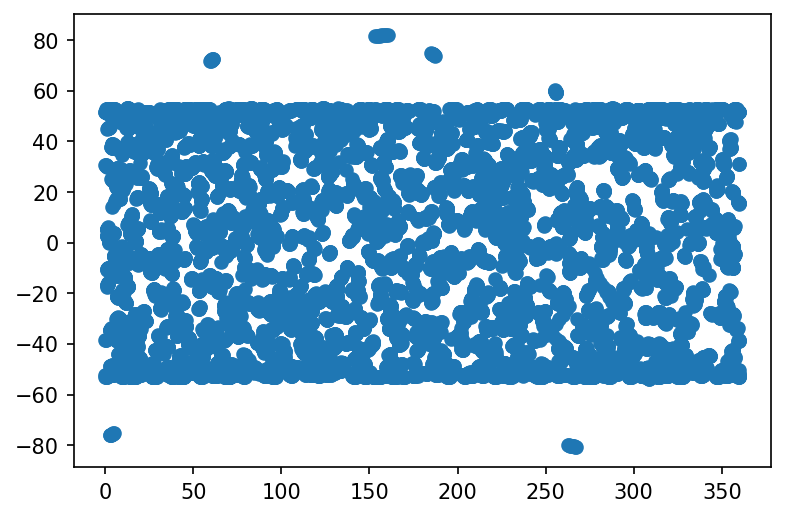

In [56]:
plt.figure(dpi=150)
plt.scatter(satra,satdec)
plt.show()

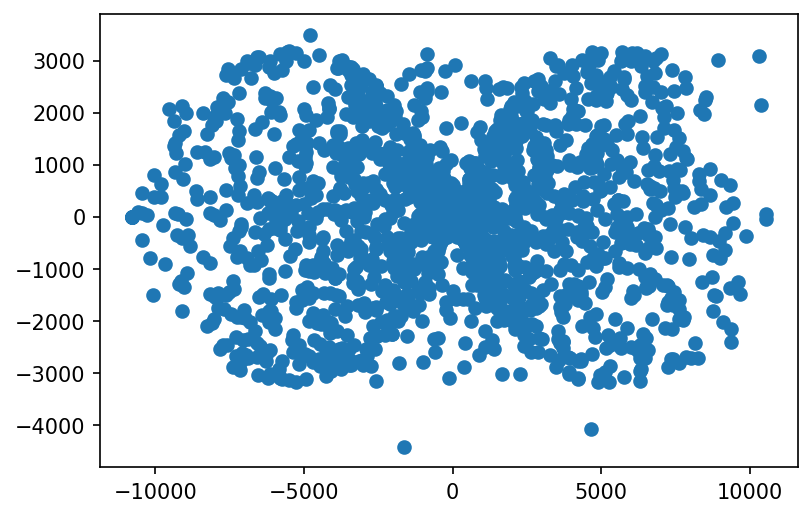

In [62]:
plt.figure(dpi=150)
plt.scatter(delraps*30,deldecps*30)
plt.show()

In [ ]:
t_before = t - TimeDelta(30.0, format='sec')
        
        # We're going to propagate every 2 seconds from 30 seconds before to 30 seconds after field time because exposure for the field is 30 seconds
        # Because of this, there will be 61 total iterations of propagations
        # If a satellite is within this time, it will leave a streak in the field image
        while count <= 61:
            jd_t = t_before + 2400000.5  # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD
    
            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))  # r is [x,y,z] for propagated satellite
        
            #Is the satellite in Earth's Shadow?
            r_parallel = np.dot(r,sv)*sv
            r_tangential = r-r_parallel
            
            if(np.linalg.norm(r_tangential)<rearth):
                #print(np.linalg.norm(r_tangential),np.linalg.norm(r))
                #yes the satellite is in Earth's shadow, no need to continue (except for the moon of course)
                break
        
       
            x, y, z = r[0], r[1], r[2] # Possible issue due to Keplerian to non-Keplerian elements
            length = np.sqrt(x**2 + y**2 + z**2)
            norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
            ra, dec = icrf2radec(norm_coords)  # convert to RA and Dec (Degrees)

In [19]:
import warnings

In [20]:
def crosstrackdistance(lat1, long1, lat2, long2, lat3, long3):
    c1 = SkyCoord(ra=long1*u.radian, dec=lat1*u.radian, frame='icrs')  
    c2 = SkyCoord(ra=long2*u.radian, dec=lat2*u.radian, frame='icrs') 
    c3 = SkyCoord(ra=long3*u.radian, dec=lat3*u.radian, frame='icrs')
    
    c1.representation_type = 'cartesian'
    c2.representation_type = 'cartesian'
    c3.representation_type = 'cartesian'
    
    P1 = c1.x.value, c1.y.value, c1.z.value
    P2 = c2.x.value, c2.y.value, c2.z.value
    P3 = c3.x.value, c3.y.value, c3.z.value
    
    S = np.cross(P1,P2)
    dot = np.dot(S,P3)
    
    dist = np.arctan2(dot/np.linalg.norm(S), np.sqrt(1 - (dot/np.linalg.norm(S))**2 )) 
    
    return dist

In [21]:
# Rubin coordinates
    # latRubin = -30.24506 (Degrees)
    # longRubin = -70.74913 (Degrees)
    # DecRubin = -30.24506 (Radians)
    # RaRubin = 289.251 (Radians)
    # Earth radius = 6371 km

working on chunk ['STARLINK-24             ', '1 44238U 19029D   21237.86036098  .00007126  00000-0  37494-3 0  9993', '2 44238  52.9979  31.4542 0001740 103.9964 256.1222 15.16678365123214']
working on chunk ['STARLINK-61             ', '1 44249U 19029Q   21237.61543563  .00009867  00000-0  43787-3 0  9994', '2 44249  52.9845   4.5063 0002069 294.3150  65.7629 15.22189982125322']
working on chunk ['STARLINK-71             ', '1 44252U 19029T   21237.87426977  .00008416  00000-0  41478-3 0  9999', '2 44252  52.9989  32.1716 0002375 104.2717 255.8541 15.18750496123844']
working on chunk ['STARLINK-43             ', '1 44257U 19029Y   21238.10491661  .00042073  00000-0  81370-3 0  9995', '2 44257  52.9970 267.2434 0002357  52.3365 307.7855 15.47360066126726']
working on chunk ['STARLINK-70             ', '1 44281U 19029AY  21237.87370611  .00171460  00000-0  13610-2 0  9990', '2 44281  52.9909 290.5443 0007442  20.1280 340.0028 15.70203708 57431']

Could not propagate STARLINK-70

workin

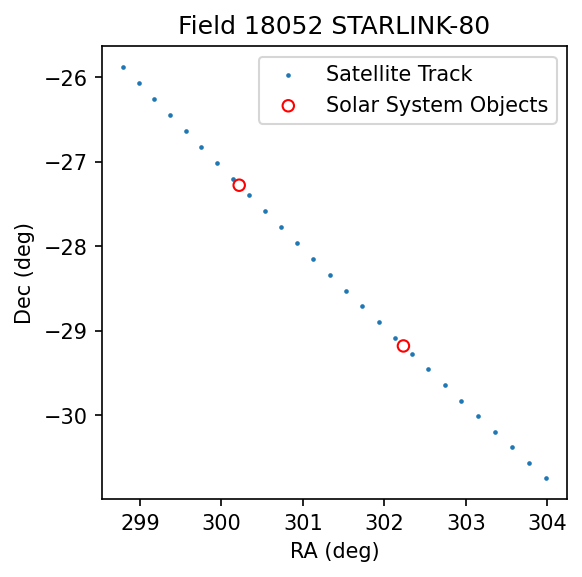

Number of objects affected: 2

Satellite times:
[59879.00219519431, 59879.00221834246, 59879.002241490605, 59879.00226463875, 59879.002287786905, 59879.00231093505, 59879.0023340832, 59879.002357231344, 59879.0023803795, 59879.002403527644, 59879.00242667579, 59879.002449823936, 59879.00247297209, 59879.002496120236, 59879.00251926838, 59879.00254241653, 59879.00256556468, 59879.00258871283, 59879.002611860975, 59879.00263500912, 59879.002658157275, 59879.00268130542, 59879.00270445357, 59879.00272760171, 59879.00275074987, 59879.00277389801, 59879.00279704616]

Right Ascension, SATELLITE:
[298.79259977512464, 298.98373075143087, 299.1754846075754, 299.3678716952895, 299.5608907995256, 299.7545523293992, 299.9488667995802, 300.1438330201982, 300.3394615572023, 300.5357591071934, 300.7327363827893, 300.93039223821137, 301.12873743670605, 301.32777882404565, 301.5275273227905, 301.72798180654337, 301.9291532577991, 302.131048663939, 302.3336791535879, 302.5370436312918, 302.7411532841814

In [41]:
# Time calculations output warnings --> ignore them
warnings.filterwarnings('ignore')


rearth=6372


# first iterate through each satellite
#for ch in chunks[:7]:
for ch in chunks:
    sat_num = ch[0].strip()  # the label for each satellite --> STARLINK-xx
    s = ch[1]  # first line of TLE set
    t = ch[2]  # second line of TLE set
    sat = sg.Satrec.twoline2rv(s, t)  
    
    print("working on chunk",ch)
    
    flag_2 = False

    # if True, satellite can't be propagated, so continue to next satellite
    if flag_2:
        continue
    
    # check each satellite against each FIELD
    for f in field_ids: #[100:1000]:
        ra_vals = []  # for satellite right ascensions
        dec_vals = []  # for satellite declinations
        sat_times = []  # for satellite times
        good_obj_times = [] # Observation times
        
        vectopsatlist = [] # for satellite topocentric vectors
        rangeobjects = [] # Distance to objects
        posrubin = []
        
        data = dfin[dfin['FieldID']==f]  # all objects in the field

        sun_vector = data[['Obs-Sun(J2000x)(km)', 'Obs-Sun(J2000y)(km)', 'Obs-Sun(J2000z)(km)']][0:1].values[0]
        sv = sun_vector/np.linalg.norm(sun_vector)
        
        ra_f = data['AstRA(deg)']  # RA for all objects
        dec_f = data['AstDec(deg)']  # Dec for all objects
        range_f = data['AstRange(km)'] # Distance for all objects
                
        min_ra, max_ra = min(ra_f), max(ra_f) # Global minimum and maximums for objects in the field in question
        min_dec, max_dec = min(dec_f), max(dec_f)

        mjd_t = data['FieldMJD'].unique()[0]  # field time
        
        t = Time(mjd_t, format='mjd')  # convert to Time format
        t_change = TimeDelta(2.0, format='sec')
        
        flag = False
        
        count = 1
        
        # Start 30 seconds before field time
        t_before = t - TimeDelta(30.0, format='sec')
        
        # We're going to propagate every 2 seconds from 30 seconds before to 30 seconds after field time because exposure for the field is 30 seconds
        # Because of this, there will be 61 total iterations of propagations
        # If a satellite is within this time, it will leave a streak in the field image
        while count <= 61:
            jd_t = t_before + 2400000.5  # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD
    
            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))  # r is [x,y,z] for propagated satellite
        
            #Is the satellite in Earth's Shadow?
            r_parallel = np.dot(r,sv)*sv
            r_tangential = r-r_parallel
            
            if(np.linalg.norm(r_tangential)<rearth):
                #print(np.linalg.norm(r_tangential),np.linalg.norm(r))
                #yes the satellite is in Earth's shadow, no need to continue (except for the moon of course)
                break
        
       
            x, y, z = r[0], r[1], r[2] # Possible issue due to Keplerian to non-Keplerian elements
            length = np.sqrt(x**2 + y**2 + z**2)
            norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
            ra, dec = icrf2radec(norm_coords)  # convert to RA and Dec (Degrees)
            
            # print(np.linalg.norm(r_tangential),np.linalg.norm(r),ra,dec)
            
            if ra != ra:  # if nan --> satellite can't be propagated to that time
                flag = True
                break  # don't bother looking at all the times 

            # if the object is in the field i.e. within 1 degree
            if (min_ra - 1.0 <= ra <= max_ra + 1.0) and (min_dec - 1.0 <= dec <= max_dec + 1.0): 
                ra_vals.append(ra)
                dec_vals.append(dec)
                sat_times.append(t_before.value) # times for satellite propagation
                
                '''
                # Calculate topocentric vector for satellite positions from Rubin (Rotation Matrix)
                ts = load.timescale()
                tsat = ts.tt_jd(t_before.value) # Appropriate time format for rotation matrix
                Rsat = ecliptic_frame.rotation_at(tsat) # Incorrect rotation matrix
                vectopsat = [x, y, z] - np.matmul(Rsat, vecrubinxyz)
                vectopsatlist.append(vectopsat)
                '''
                
                # Calculate topocentric vector for satellite positions from Rubin (WGS84)
                tsat = Time(t_before.value, format='jd')
                vecrubinxyz = getObserverStates(tsat, observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                     observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
                vectopsat = [x, y, z] - vecrubinxyz
                vectopsatlist.append(vectopsat)
            
            t_before += t_change  # Propagate 2.0 seconds
            count += 1 
            
        if flag:
            print()
            print("Could not propagate " + sat_num)
            print()
            flag_2 = True
            break  # break out of for loop of the fields
                
        # Only satellite points that are within the field of objects
        if any(ra_vals) and any(dec_vals):
            good_obj_ra, good_obj_dec, good_obj_range = [], [], []
            
            obj_count = 0
            
            # for satellites
           
            min_ra_track, max_ra_track = ra_vals[0], ra_vals[-1]
            min_dec_track, max_dec_track = dec_vals[0], dec_vals[-1]
        
            
            min_long, max_long = np.deg2rad(min_ra_track), np.deg2rad(max_ra_track)  # Convert to radians 
        
            min_lat, max_lat = np.deg2rad(min_dec_track), np.deg2rad(max_dec_track)  
            

            for obj_r, obj_d, obj_range in zip(ra_f, dec_f, range_f): 
                obj_long = np.deg2rad(obj_r)
                obj_lat = np.deg2rad(obj_d)

                bound_d = 2.0 * np.pi/(180*3600)  # 2 arcseconds in radians

                # calculate cross track distance between satellite streak and objects
                dist = crosstrackdistance(min_lat, min_long, max_lat, max_long, obj_lat, obj_long) 
                
                # an object is considered obstructed if the satellite streak is within 2 arcseconds of it
                if (abs(dist) <= bound_d) and ((min_lat <= obj_lat <= max_lat) or (min_long <= obj_long <= max_long)):
                    good_obj_ra.append(obj_r)
                    good_obj_dec.append(obj_d)
                    good_obj_range.append(obj_range)
                    good_obj_times.append(t_before.value) # add observation time for objects
                    obj_count += 1 
                    
                    
            # only plot objects that are obstructed 
            if any(good_obj_ra):
#                 plt.figure(dpi=150,figsize=(4,4))
#                 plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite')
#                 plt.scatter(good_obj_ra, good_obj_dec, s=1.5, label='Objects')
#                 title = "Field " + str(f) + " " + sat_num
#                 plt.title(title)
#                 plt.xlabel('RA (deg)')
#                 plt.ylabel('Dec (deg)')
#                 plt.legend()
# #                 plt.savefig(title)
#                 plt.show()


                plt.figure(dpi=150,figsize=(4,4))
                plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite Track')
                #plt.plot(ra_vals, dec_vals, label='Satellite')
                plt.scatter(good_obj_ra, good_obj_dec, s=30, label='Solar System Objects', facecolors='none', edgecolors='r')
                title = "Field " + str(f) + " " + sat_num
                plt.title(title)
                plt.xlabel('RA (deg)')
                plt.ylabel('Dec (deg)')
                plt.legend()
#                 plt.savefig(title)
                plt.show()

                print("Number of objects affected: " + str(obj_count))
                print()
                print("Satellite times:")
                print(str(sat_times))
                
                print()
                print("Right Ascension, SATELLITE:")
                print(ra_vals)
                print("Declination, SATELLITE")
                print(dec_vals)
                print()
                
                print()
                print("Right Ascension, OBJECTS:")
                print(good_obj_ra)
                print("Declination, OBJECTS")
                print(good_obj_dec)
                print()
                
                
                # Topocentric vector for relevant satellite positions 
                vectopsatlistdisp = np.array(vectopsatlist)
                print("Topocentric vector for satellite positions from Rubin (km):")
                print(vectopsatlistdisp)
                
                '''
                # Topocentric vector for relevant objects
                for obj in range(0, len(good_obj_ra)):
                    ts = load.timescale()
                    tobj = ts.tt_jd(good_obj_times[obj]) # Appropriate time format for rotation matrix
                    R = ecliptic_frame.rotation_at(tobj) # Rotation matrix
                    objpos_xyz = good_obj_range[obj]*radec2icrf(good_obj_ra[obj], good_obj_dec[obj])
                    vectopobj = objpos_xyz - np.matmul(R, vecrubinxyz)
            
                    print('Topocentric vector for object', obj, '(km):')
                    print(vectopobj)
                '''
                
                # Topocentric vector for relevant objects
                for obj in range(0, len(good_obj_ra)):
                    tobj = Time(good_obj_times[obj], format='jd') 
                    vecrubinxyz = getObserverStates(tobj, observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                     observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
                    objpos_xyz = good_obj_range[obj]*radec2icrf(good_obj_ra[obj], good_obj_dec[obj])
                    vectopobj = objpos_xyz - vecrubinxyz
            
                    print('Topocentric vector for object', obj, '(km):')
                    print(vectopobj)
                

In [ ]:
# Time calculations output warnings --> ignore them
warnings.filterwarnings('ignore')


# List for calculation times
calctime = [] 
sat_cross=[]
obs_affected=[]

rearth=6372


# first iterate through each satellite
#for ch in chunks[:7]:
for ch in chunks:
    sat_num = ch[0].strip()  # the label for each satellite --> STARLINK-xx
    s = ch[1]  # first line of TLE set
    t = ch[2]  # second line of TLE set
    sat = sg.Satrec.twoline2rv(s, t)  
    
    print("working on chunk",ch)
    
    flag_2 = False

    # if True, satellite can't be propagated, so continue to next satellite
    if flag_2:
        continue
    
    # check each satellite against each FIELD
    for f in field_ids: #[100:1000]:
        ra_vals = []  # for satellite right ascensions
        dec_vals = []  # for satellite declinations
        sat_times = []  # for satellite times
        good_obj_times = [] # Observation times
        
        vectopsatlist = [] # for satellite topocentric vectors
        rangeobjects = [] # Distance to objects
        posrubin = []
        
        data = dfin[dfin['FieldID']==f]  # all objects in the field

        sun_vector = data[['Obs-Sun(J2000x)(km)', 'Obs-Sun(J2000y)(km)', 'Obs-Sun(J2000z)(km)']][0:1].values[0]
        sv = sun_vector/np.linalg.norm(sun_vector)
        
        ra_f = data['AstRA(deg)']  # RA for all objects
        dec_f = data['AstDec(deg)']  # Dec for all objects
        range_f = data['AstRange(km)'] # Distance for all objects
                
        min_ra, max_ra = min(ra_f), max(ra_f) # Global minimum and maximums for objects in the field in question
        min_dec, max_dec = min(dec_f), max(dec_f)

        mjd_t = data['FieldMJD'].unique()[0]  # field time
        
        t = Time(mjd_t, format='mjd')  # convert to Time format
        t_change = TimeDelta(2.0, format='sec')
        
        flag = False
        
        count = 1
        
        # Start 30 seconds before field time
        t_before = t - TimeDelta(30.0, format='sec')
        
        # We're going to propagate every 2 seconds from 30 seconds before to 30 seconds after field time because exposure for the field is 30 seconds
        # Because of this, there will be 61 total iterations of propagations
        # If a satellite is within this time, it will leave a streak in the field image
        while count <= 61:
            jd_t = t_before + 2400000.5  # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD
    
            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 12))  # r is [x,y,z] for propagated satellite
        
            #Is the satellite in Earth's Shadow?
            r_parallel = np.dot(r,sv)*sv
            r_tangential = r-r_parallel
            
            if(np.linalg.norm(r_tangential)<rearth):
                #print(np.linalg.norm(r_tangential),np.linalg.norm(r))
                #yes the satellite is in Earth's shadow, no need to continue (except for the moon of course)
                break
        
       
            x, y, z = r[0], r[1], r[2] # Possible issue due to Keplerian to non-Keplerian elements
            length = np.sqrt(x**2 + y**2 + z**2)
            norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
            ra, dec = icrf2radec(norm_coords)  # convert to RA and Dec (Degrees)
            
            # print(np.linalg.norm(r_tangential),np.linalg.norm(r),ra,dec)
            
            if ra != ra:  # if nan --> satellite can't be propagated to that time
                flag = True
                break  # don't bother looking at all the times 

            # if the object is in the field i.e. within 1 degree
            if (min_ra - 1.0 <= ra <= max_ra + 1.0) and (min_dec - 1.0 <= dec <= max_dec + 1.0): 
                ra_vals.append(ra)
                dec_vals.append(dec)
                sat_times.append(t_before.value) # times for satellite propagation
                
                '''
                # Calculate topocentric vector for satellite positions from Rubin (Rotation Matrix)
                ts = load.timescale()
                tsat = ts.tt_jd(t_before.value) # Appropriate time format for rotation matrix
                Rsat = ecliptic_frame.rotation_at(tsat) # Incorrect rotation matrix
                vectopsat = [x, y, z] - np.matmul(Rsat, vecrubinxyz)
                vectopsatlist.append(vectopsat)
                '''
                
                # Calculate topocentric vector for satellite positions from Rubin (WGS84)
                tsat = Time(t_before.value, format='jd')
                vecrubinxyz = getObserverStates(tsat, observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                     observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
                vectopsat = [x, y, z] - vecrubinxyz
                vectopsatlist.append(vectopsat)
            
            t_before += t_change  # Propagate 2.0 seconds
            count += 1 
            
        if flag:
            print()
            print("Could not propagate " + sat_num)
            print()
            flag_2 = True
            break  # break out of for loop of the fields
                
        # Only satellite points that are within the field of objects
        if any(ra_vals) and any(dec_vals):
            good_obj_ra, good_obj_dec, good_obj_range = [], [], []
            
            obj_count = 0
            
            # for satellites
           
            min_ra_track, max_ra_track = ra_vals[0], ra_vals[-1]
            min_dec_track, max_dec_track = dec_vals[0], dec_vals[-1]
        
            
            min_long, max_long = np.deg2rad(min_ra_track), np.deg2rad(max_ra_track)  # Convert to radians 
        
            min_lat, max_lat = np.deg2rad(min_dec_track), np.deg2rad(max_dec_track)  
            

            for obj_r, obj_d, obj_range in zip(ra_f, dec_f, range_f): 
                obj_long = np.deg2rad(obj_r)
                obj_lat = np.deg2rad(obj_d)

                bound_d = 2.0 * np.pi/(180*3600)  # 2 arcseconds in radians

                # calculate cross track distance between satellite streak and objects
                dist = crosstrackdistance(min_lat, min_long, max_lat, max_long, obj_lat, obj_long) 
                
                # an object is considered obstructed if the satellite streak is within 2 arcseconds of it
                if (abs(dist) <= bound_d) and ((min_lat <= obj_lat <= max_lat) or (min_long <= obj_long <= max_long)):
                    good_obj_ra.append(obj_r)
                    good_obj_dec.append(obj_d)
                    good_obj_range.append(obj_range)
                    good_obj_times.append(t_before.value) # add observation time for objects
                    obj_count += 1 
                    
                    
            # only plot objects that are obstructed 
            if any(good_obj_ra):
#                 plt.figure(dpi=150,figsize=(4,4))
#                 plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite')
#                 plt.scatter(good_obj_ra, good_obj_dec, s=1.5, label='Objects')
#                 title = "Field " + str(f) + " " + sat_num
#                 plt.title(title)
#                 plt.xlabel('RA (deg)')
#                 plt.ylabel('Dec (deg)')
#                 plt.legend()
# #                 plt.savefig(title)
#                 plt.show()


                plt.figure(dpi=150,figsize=(4,4))
                plt.scatter(ra_vals, dec_vals, s=1.5, label='Satellite Track')
                #plt.plot(ra_vals, dec_vals, label='Satellite')
                plt.scatter(good_obj_ra, good_obj_dec, s=30, label='Solar System Objects', facecolors='none', edgecolors='r')
                title = "Field " + str(f) + " " + sat_num
                plt.title(title)
                plt.xlabel('RA (deg)')
                plt.ylabel('Dec (deg)')
                plt.legend()
#                 plt.savefig(title)
                plt.show()

                print("Number of objects affected: " + str(obj_count))
                print()
                print("Satellite times:")
                print(str(sat_times))
                
                print()
                print("Right Ascension, SATELLITE:")
                print(ra_vals)
                print("Declination, SATELLITE")
                print(dec_vals)
                print()
                
                print()
                print("Right Ascension, OBJECTS:")
                print(good_obj_ra)
                print("Declination, OBJECTS")
                print(good_obj_dec)
                print()
                
                
                # Topocentric vector for relevant satellite positions 
                vectopsatlistdisp = np.array(vectopsatlist)
                print("Topocentric vector for satellite positions from Rubin (km):")
                print(vectopsatlistdisp)
                
                '''
                # Topocentric vector for relevant objects
                for obj in range(0, len(good_obj_ra)):
                    ts = load.timescale()
                    tobj = ts.tt_jd(good_obj_times[obj]) # Appropriate time format for rotation matrix
                    R = ecliptic_frame.rotation_at(tobj) # Rotation matrix
                    objpos_xyz = good_obj_range[obj]*radec2icrf(good_obj_ra[obj], good_obj_dec[obj])
                    vectopobj = objpos_xyz - np.matmul(R, vecrubinxyz)
            
                    print('Topocentric vector for object', obj, '(km):')
                    print(vectopobj)
                '''
                
                # Topocentric vector for relevant objects
                for obj in range(0, len(good_obj_ra)):
                    tobj = Time(good_obj_times[obj], format='jd') 
                    vecrubinxyz = getObserverStates(tobj, observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                     observerLongitudeDeg=70.74913,observerLongitudeDirection='E',observerElevationMeters=2663)
                    objpos_xyz = good_obj_range[obj]*radec2icrf(good_obj_ra[obj], good_obj_dec[obj])
                    vectopobj = objpos_xyz - vecrubinxyz
            
                    print('Topocentric vector for object', obj, '(km):')
                    print(vectopobj)
                

In [ ]:
# Minimum propagation time for satellites
mintime = min(calctime)
print('Minimum propagation time: ', mintime)

print()
maxtime = max(calctime)
# Maximum propagation time for satellites
print('Maximum propagation time: ', maxtime)

print()
avtime = sum(calctime)/len(calctime)
print('Average propagation time: ', avtime)

print()
totaltime = sum(calctime)
print('Total run time: ', totaltime)